In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense, MaxPooling2D
from keras.optimizers import Adam
import keras.backend as K

2023-12-13 03:26:10.404410: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-13 03:26:11.284026: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!pip install numpy pandas matplotlib seaborn plotly requests tqdm opencv-python pillow wandb -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [3]:
import tensorflow as tf
import os
import shutil
import random
import pandas as pd

# 定义文件夹路径
dataset_path = "Rice_Image_Dataset"  # 替换成您的数据集路径
dataset_name = "Rice_Image_Dataset"  # 数据集名称
# 定义类别和比例
classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
train_frac = 0.7
val_frac = 0.15
test_frac = 0.15
# 创建训练集、验证集和测试集文件夹
os.makedirs(os.path.join(dataset_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'val'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'test'), exist_ok=True)

In [4]:
# Creating subfolders for each category in the train and test folders
for PlantVillage in classes:
    os.makedirs(os.path.join(dataset_path, 'train', PlantVillage), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, 'test', PlantVillage), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, 'val', PlantVillage), exist_ok=True)

In [5]:
# 创建一个空的 DataFrame
df = pd.DataFrame(columns=['class', 'trainset', 'testset','valset'])

print('{:^18} {:^18} {:^18} {:^18}'.format('类别', '训练集数据个数', '测试集数据个数','验证集数据个数'))

for rice in classes: # 遍历每个类别
    dataset_path2 = "Rice_Image_Dataset" 
    # 读取该类别的所有图像文件名
    old_dir = os.path.join(dataset_path, rice)
    images_filename = os.listdir(old_dir)
    random.shuffle(images_filename) # 随机打乱

    # 划分训练集和测试集
    testset_number = int(len(images_filename) * test_frac) 
    valset_number = int(len(images_filename) * val_frac)
    train_number = int(len(images_filename) * train_frac)


    testset_images = images_filename[:testset_number]
    valset_images = images_filename[testset_number:testset_number + valset_number]
    trainset_images = images_filename[testset_number + valset_number: testset_number + valset_number + train_number]


    # 移动图像至 test 目录
    for image in testset_images:
        old_img_path = os.path.join(dataset_path, rice, image)         # 获取原始文件路径
        new_test_path = os.path.join(dataset_path, 'test', rice, image) # 获取 test 目录的新文件路径
        shutil.move(old_img_path, new_test_path) # 移动文件

    # 移动图像至 train 目录
    for image in trainset_images:
        old_img_path = os.path.join(dataset_path, rice, image)           # 获取原始文件路径
        new_train_path = os.path.join(dataset_path, 'train', rice, image) # 获取 train 目录的新文件路径
        shutil.move(old_img_path, new_train_path) # 移动文件
    # 移动图像至 val 目录
    for image in valset_images:
        old_img_path = os.path.join(dataset_path, rice, image)           # 获取原始文件路径
        new_val_path = os.path.join(dataset_path, 'val', rice, image) # 获取 train 目录的新文件路径
        shutil.move(old_img_path, new_val_path) # 移动文件
    # 删除旧文件夹
    assert len(os.listdir(old_dir)) == 0 # 确保旧文件夹中的所有图像都被移动走
    shutil.rmtree(old_dir) # 删除文件夹
    
    # 工整地输出每一类别的数据个数
    print('{:^18} {:^18} {:^18} {:^18}'.format(rice, len(trainset_images), len(testset_images),len(valset_images)))
    
    # 保存到表格中
    df = pd.concat([
    df,
    pd.DataFrame({
        'class': [rice],
        'trainset': [len(trainset_images)],
        'testset': [len(testset_images)],
        'valset': [len(valset_images)]
      })
], ignore_index=True)

# 重命名数据集文件夹
shutil.move(dataset_path, dataset_name+'_split')

# 数据集各类别数量统计表格，导出为 csv 文件
df['total'] = df['trainset'] + df['testset'] + df['valset']
df.to_csv('数据量统计.csv', index=False)

        类别              训练集数据个数            测试集数据个数            验证集数据个数      
     Arborio             10500               2250               2250       
     Basmati             10500               2250               2250       
      Ipsala             10500               2250               2250       
     Jasmine             10500               2250               2250       
    Karacadag            10500               2250               2250       


In [6]:
df

,class,trainset,testset,valset,total
0,Arborio,10500,2250,2250,15000
1,Basmati,10500,2250,2250,15000
2,Ipsala,10500,2250,2250,15000
3,Jasmine,10500,2250,2250,15000
4,Karacadag,10500,2250,2250,15000


In [7]:
dataset_dir = 'Rice_Image_Dataset_split'

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,  # Specify the validation split here
    fill_mode='nearest'
)

In [10]:
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    subset='training'  # Use 'training' subset for training data
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    shuffle = False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    shuffle = False
)

Found 42000 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


In [ ]:
combined_model.save('rice_model.h1')

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 加载预训练的ResNet模型，不包括顶层（Top）
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# 冻结预训练模型的权重，使其不可训练
base_model.trainable = False

# 在ResNet模型之上构建自定义的分类器
model3 = Sequential()
model3.add(base_model)
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dense(5, activation='softmax'))  # 你的输出类别数量

# 编译模型
model3.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 创建图像数据生成器
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# 从目录中获取训练数据
train_generator = train_datagen.flow_from_directory(
    directory='Rice_Image_Dataset_split/train',
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical'
)

# 从目录中获取验证数据
validation_generator = val_datagen.flow_from_directory(
    directory='Rice_Image_Dataset_split/val',
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical'
)

# 训练模型
history = model3.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator
)


Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Epoch 1/30


2023-12-13 03:32:42.563143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-13 03:32:43.655146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-13 03:32:44.195728: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1ccdcd50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-13 03:32:44.195796: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-12-13 03:32:44.211774: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-13 03:32:44.417020: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

3282/3282 [==============================] - 84s 24ms/step - loss: 0.1748 - accuracy: 0.9355 - val_loss: 0.0897 - val_accuracy: 0.9671
Epoch 2/30
3282/3282 [==============================] - 84s 26ms/step - loss: 0.1089 - accuracy: 0.9602 - val_loss: 0.1195 - val_accuracy: 0.9595
Epoch 3/30
3282/3282 [==============================] - 76s 23ms/step - loss: 0.0977 - accuracy: 0.9662 - val_loss: 0.0772 - val_accuracy: 0.9751
Epoch 4/30
3282/3282 [==============================] - 76s 23ms/step - loss: 0.0897 - accuracy: 0.9680 - val_loss: 0.0779 - val_accuracy: 0.9727
Epoch 5/30
3282/3282 [==============================] - 84s 26ms/step - loss: 0.0828 - accuracy: 0.9710 - val_loss: 0.0866 - val_accuracy: 0.9680
Epoch 6/30
3282/3282 [==============================] - 84s 26ms/step - loss: 0.0774 - accuracy: 0.9721 - val_loss: 0.0625 - val_accuracy: 0.9783
Epoch 7/30
3282/3282 [==============================] - 76s 23ms/step - loss: 0.0768 - accuracy: 0.9727 - val_loss: 0.0733 - val_accura

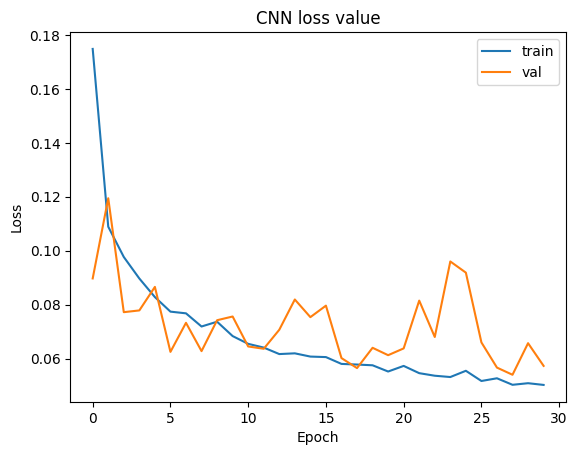

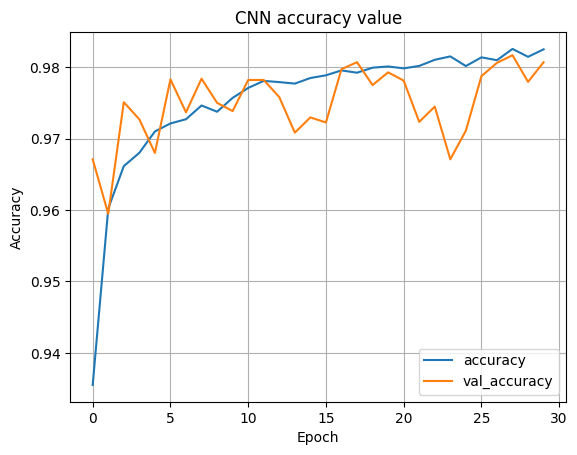

In [16]:
import matplotlib.pyplot as plt
# 绘制loss图
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("CNN loss value")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.grid(True)



# 绘制准确率
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title("CNN accuracy value")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
test_loss, test_acc = model3.evaluate(test_generator)
print("Test accuracy:", test_acc)

704/704 [==============================] - 14s 20ms/step - loss: 0.0666 - accuracy: 0.9777
Test accuracy: 0.9776889085769653


704/704 [==============================] - 13s 17ms/step


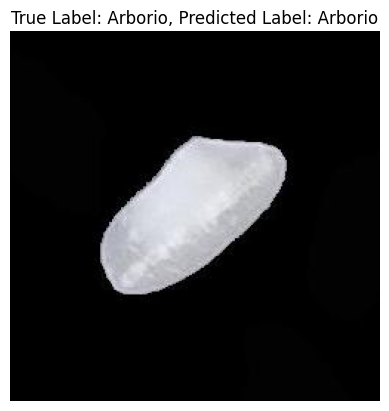

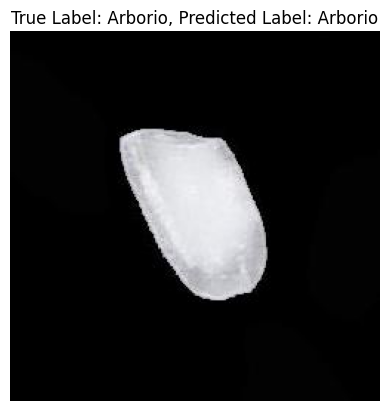

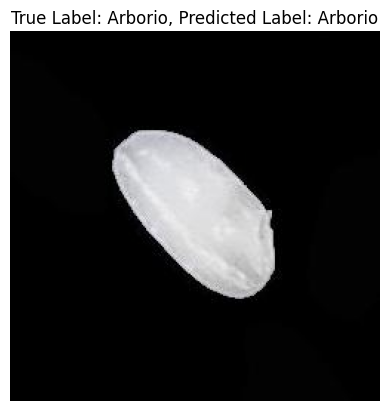

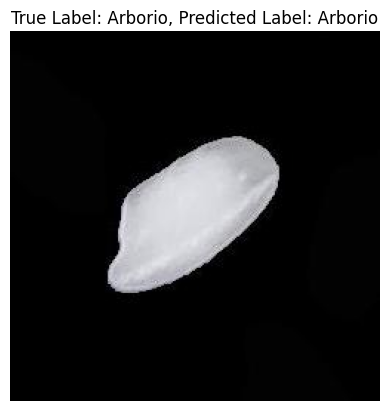

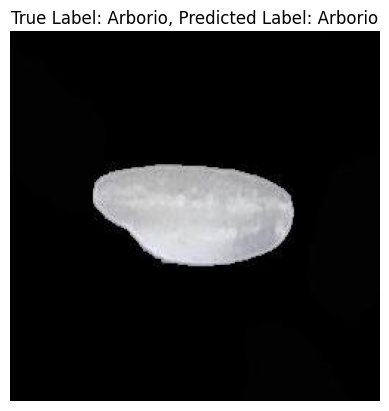

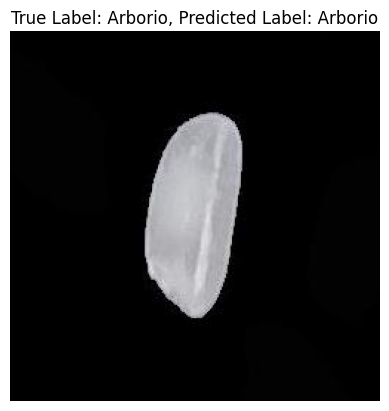

In [18]:
import numpy as np

predictions = model3.predict(test_generator)
from tensorflow.keras.preprocessing import image
# Retrieve the true class labels
true_labels = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Display the first few images with true and predicted labels
for i in range(6):  # Display the first 5 images (you can change this number)
    plt.figure()
    plt.imshow(image.load_img(os.path.join(test_dir, test_generator.filenames[i])))
    plt.title(f"True Label: {class_labels[true_labels[i]]}, Predicted Label: {class_labels[np.argmax(predictions[i])]}")
    plt.axis('off')
    plt.show()

704/704 [==============================] - 11s 15ms/step


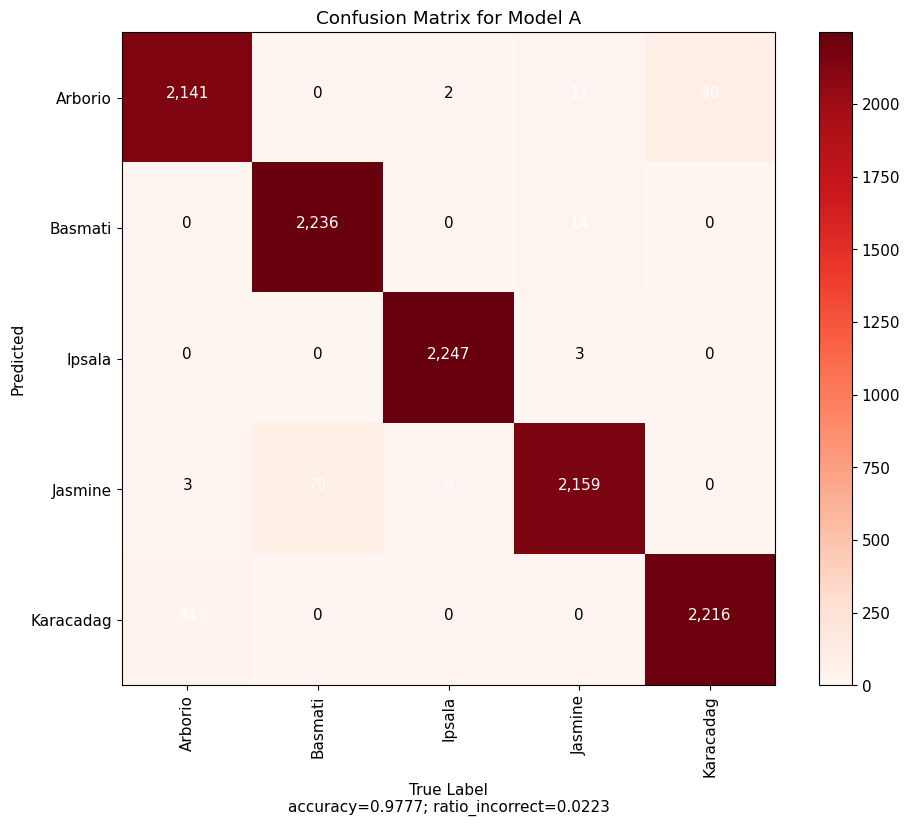

In [19]:
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(validation_generator, model3, test_generator, model_name):
    plt.rcParams.update({'font.size': 11})
    
    predictions = model3.predict(test_generator, steps=len(test_generator), verbose=1)
    preds = np.argmax(predictions, axis=1)
    predictions = tf.nn.softmax(predictions, axis=1)
    
    labels = validation_generator.classes
    
    plot_labels = np.array([i for i in validation_generator.class_indices.keys()])
    
    cm = confusion_matrix(labels, preds)

    ratio_correct = np.trace(cm) / np.sum(cm)
    ratio_incorrect = 1 - ratio_correct

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Reds')
    plt.colorbar()

    ticks = np.arange(len(plot_labels))
    plt.xticks(ticks, plot_labels, rotation=90)
    plt.yticks(ticks, plot_labels)

    plt.title(f'Confusion Matrix for {model_name}')
    # plt.grid(b=False)

    threshold = 4
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > threshold else 'black')
    
    plt.tight_layout()
    plt.ylabel('Predicted')
    plt.xlabel('True Label\naccuracy={:0.4f}; ratio_incorrect={:0.4f}'.format(
        ratio_correct, ratio_incorrect
    ))

# 使用方式：
plot_confusion_matrix(validation_generator, model3, test_generator, 'Model A')

704/704 [==============================] - 12s 16ms/step


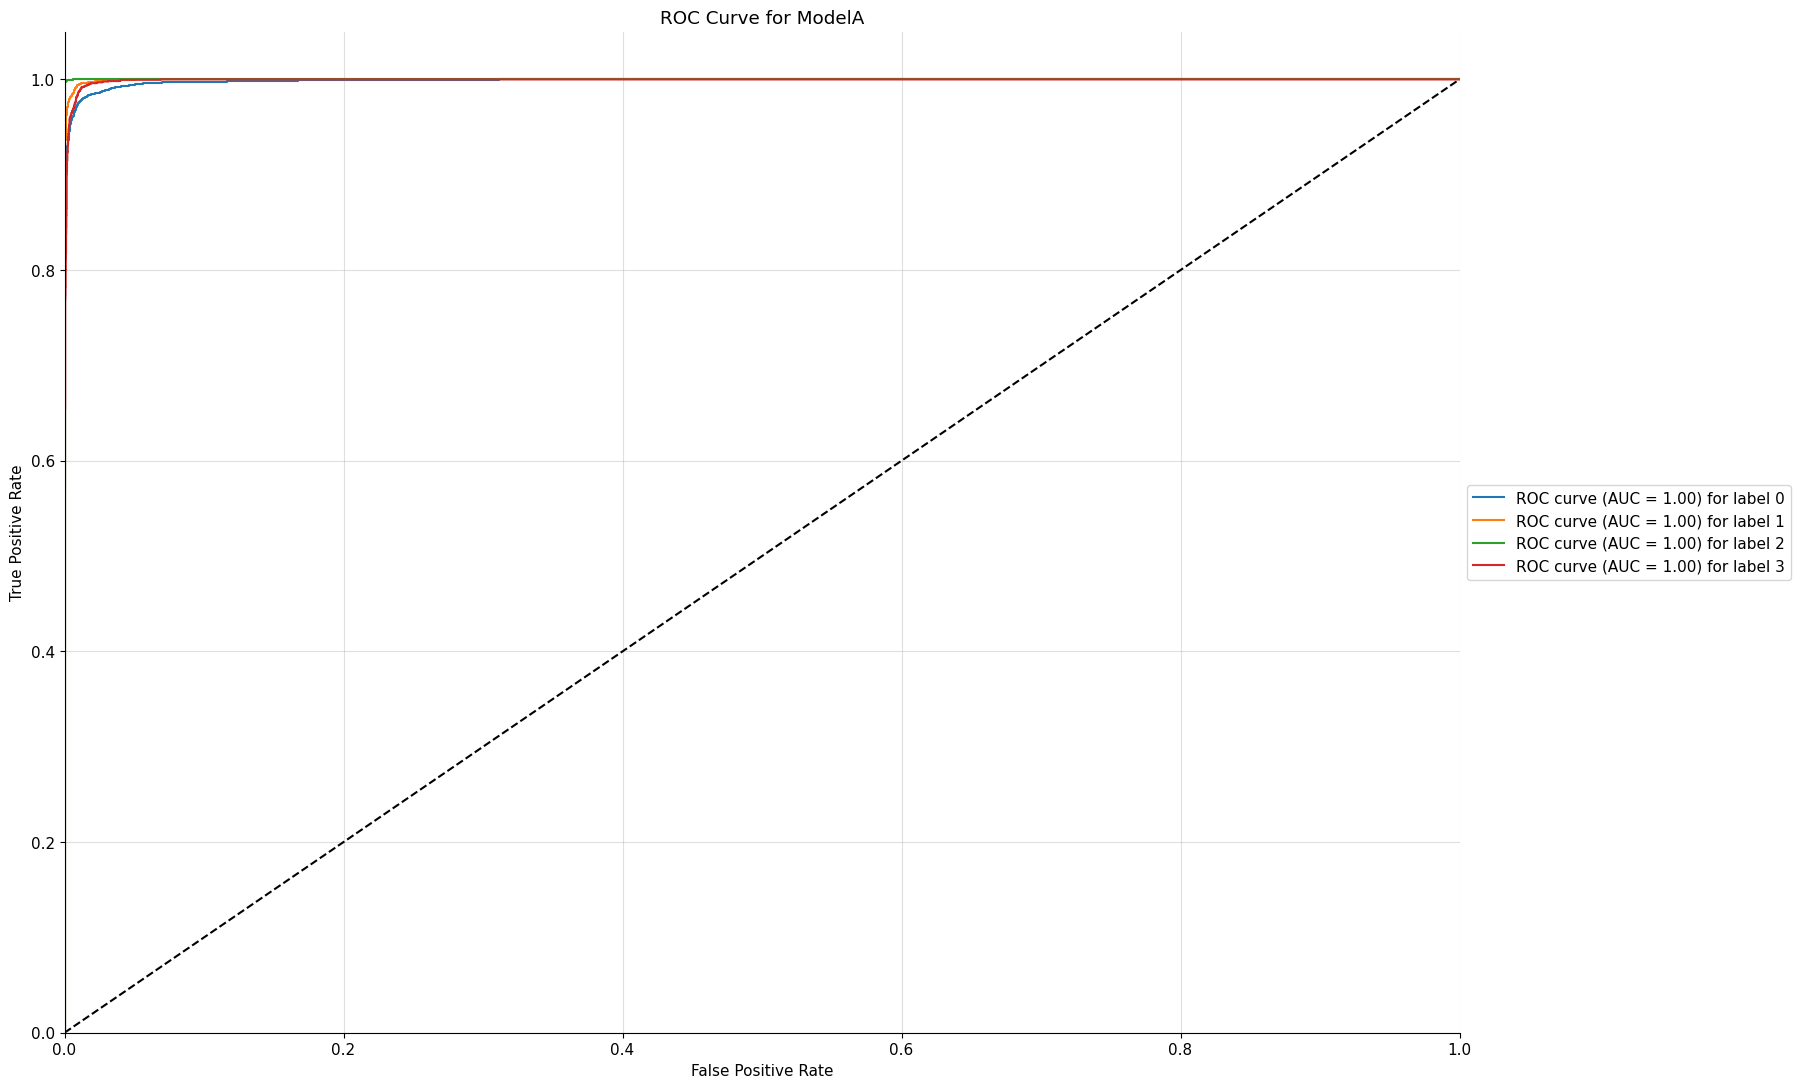

In [20]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_roc_curve(model3, test_generator, model_name):
    y_true = test_generator.classes
    predictions = model3.predict(test_generator, steps=len(test_generator), verbose=1)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fig, ax = plt.subplots(figsize=(18, 13))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')

    for i in range(4):
        ax.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for label %i' % (roc_auc[i], i))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

# 使用方式：
plot_roc_curve(model3, test_generator, 'ModelA')

In [21]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

def class_report(validation_generator, model3, test_generator):
    predictions = model3.predict(test_generator, steps=len(test_generator), verbose=1)
    preds = np.argmax(predictions, axis=1)
    labels = validation_generator.classes
    names = np.array([i for i in validation_generator.class_indices.keys()])
    report_dict = classification_report(labels, preds, target_names=names, output_dict=True)
    df = pd.DataFrame.from_dict(report_dict).transpose()
    return df
class_report(validation_generator, model3, test_generator)

704/704 [==============================] - 11s 15ms/step


,precision,recall,f1-score,support
Arborio,0.983012,0.951556,0.967028,2250.000000
Basmati,0.965875,0.993778,0.979628,2250.000000
Ipsala,0.995128,0.998667,0.996894,2250.000000
Jasmine,0.984496,0.959556,0.971866,2250.000000
Karacadag,0.960971,0.984889,0.972783,2250.000000
accuracy,0.977689,0.977689,0.977689,0.977689
macro avg,0.977897,0.977689,0.977640,11250.000000
weighted avg,0.977897,0.977689,0.977640,11250.000000


In [22]:
from sklearn.metrics import confusion_matrix

def sensitivity_specificity(model3, test_generator):
    # 获取验证集上的真实标签
    y_true = test_generator.classes

    # 使用模型进行预测
    predictions = model3.predict(test_generator, steps=len(test_generator), verbose=1)
    y_pred = np.argmax(predictions, axis=1)

    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)

    # 计算敏感性和特异性
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    return sensitivity, specificity

# 使用方式：
sensitivity, specificity = sensitivity_specificity(model3, test_generator)
print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

704/704 [==============================] - 12s 17ms/step
Sensitivity: 1.0, Specificity: 1.0


704/704 [==============================] - 11s 16ms/step


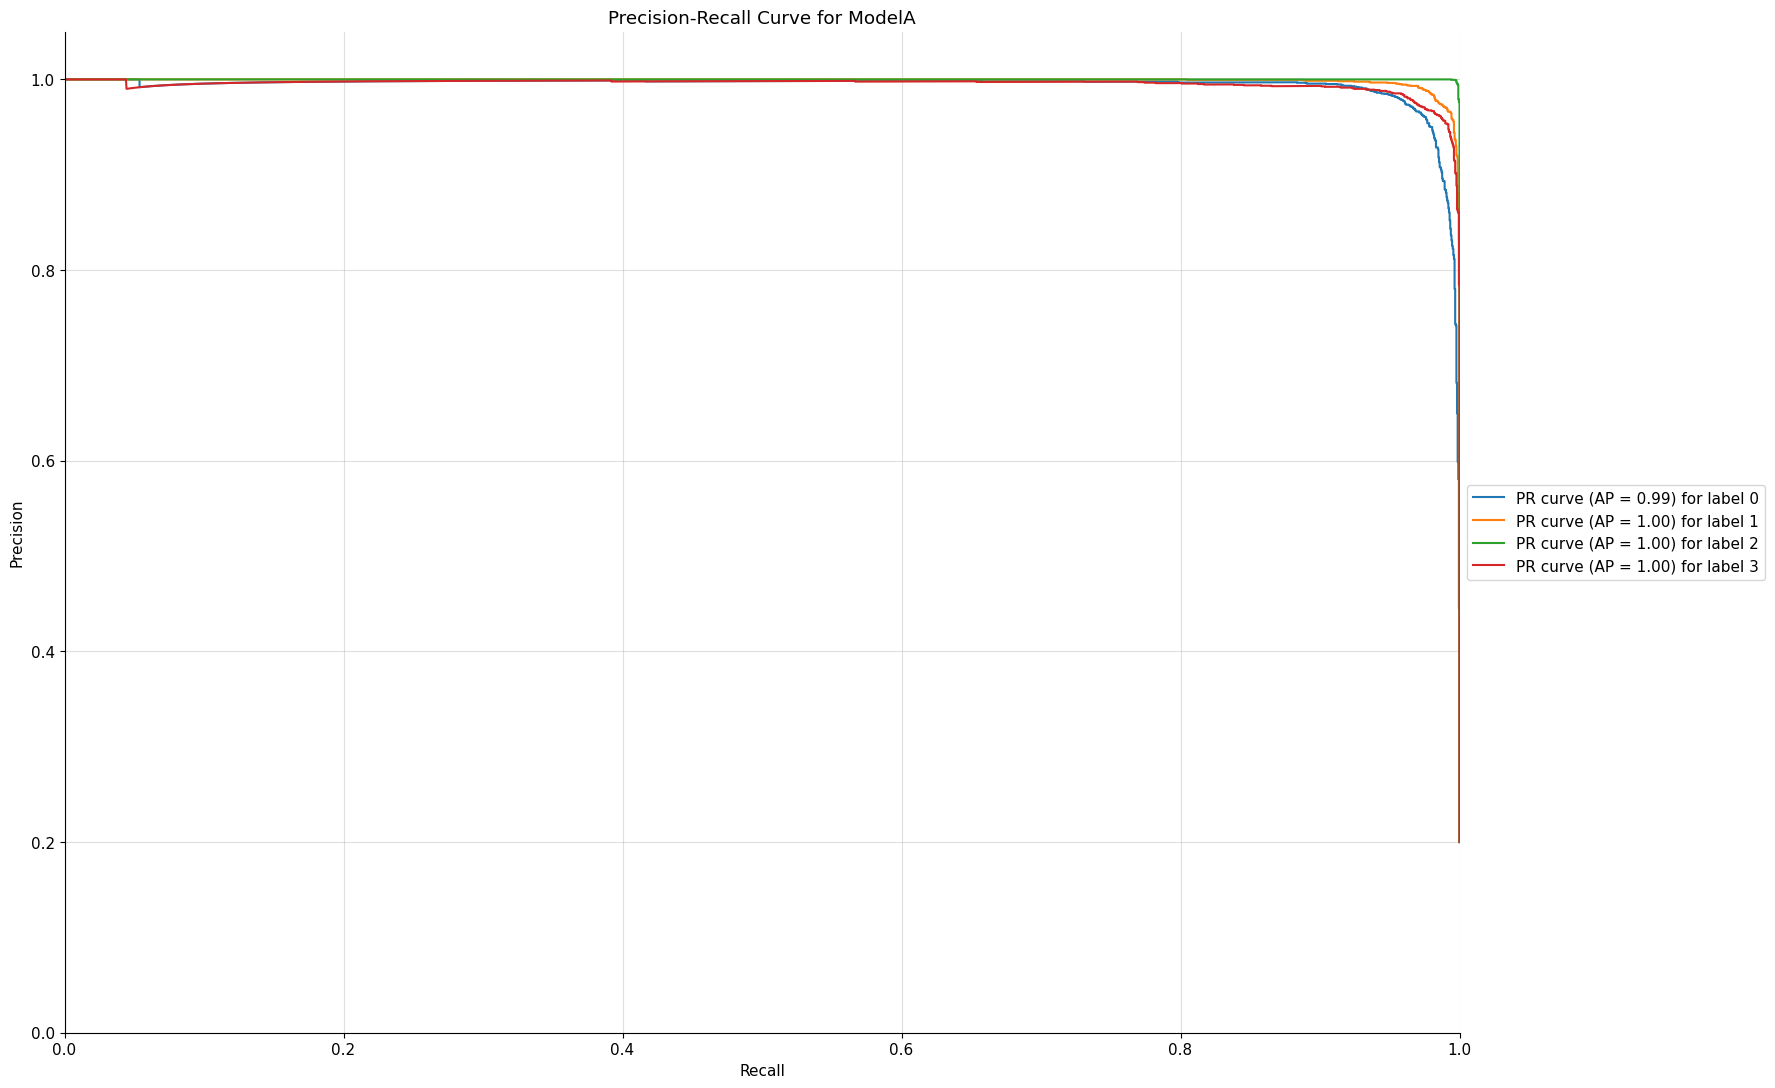

In [23]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def plot_precision_recall_curve(model3, test_generator, model_name):
    # 获取验证集上的真实标签
    y_true = test_generator.classes

    # 使用模型进行预测
    predictions = model3.predict(test_generator, steps=len(test_generator), verbose=1)

    # 初始化 Precision 和 Recall 字典
    precision = dict()
    recall = dict()
    average_precision = dict()

    # 计算每个类别的 Precision 和 Recall
    for i in range(4):
        precision[i], recall[i], _ = precision_recall_curve(y_true == i, predictions[:, i])
        average_precision[i] = auc(recall[i], precision[i])

    # 绘制 Precision-Recall 曲线
    fig, ax = plt.subplots(figsize=(18, 13))
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve for {model_name}')

    for i in range(4):
        ax.plot(recall[i], precision[i], label='PR curve (AP = %0.2f) for label %i' % (average_precision[i], i))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

# 使用方式：
plot_precision_recall_curve(model3, test_generator, 'ModelA')